## HW3: Decision Tree, Random Forest, and Adaboost
In hw3, you need to implement decision tree, random forest and adaboost by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [1]:
#!pip install sklearn

## Load data

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

In [3]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [4]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from the course sludes on E3

In [9]:
x_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,9.423,27.88,59.26,271.3,0.08123,0.04971,0.00000,0.00000,0.1742,0.06059,...,10.49,34.24,66.50,330.6,0.1073,0.07158,0.0000,0.00000,0.2475,0.06969
1,12.070,13.44,77.83,445.2,0.11000,0.09009,0.03781,0.02798,0.1657,0.06608,...,13.45,15.77,86.92,549.9,0.1521,0.16320,0.1622,0.07393,0.2781,0.08052
2,19.160,26.60,126.20,1138.0,0.10200,0.14530,0.19210,0.09664,0.1902,0.06220,...,23.72,35.90,159.80,1724.0,0.1782,0.38410,0.5754,0.18720,0.3258,0.09720
3,19.000,18.91,123.40,1138.0,0.08217,0.08028,0.09271,0.05627,0.1946,0.05044,...,22.32,25.73,148.20,1538.0,0.1021,0.22640,0.3207,0.12180,0.2841,0.06541
4,17.540,19.32,115.10,951.6,0.08968,0.11980,0.10360,0.07488,0.1506,0.05491,...,20.42,25.84,139.50,1239.0,0.1381,0.34200,0.3508,0.19390,0.2928,0.07867


In [13]:
def gini(sequence):
    values, counts = np.unique(sequence, return_counts=True)
    p_counts = counts / np.sum(counts).item()
    return 1 - p_counts @ p_counts

def entropy(sequence):
    values, counts = np.unique(sequence, return_counts=True)
    p_counts = counts / np.sum(counts).item()
    return -(p_counts @ np.log2(p_counts))

In [14]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [15]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [16]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [46]:
rng = np.random.default_rng()

class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        """Decision Tree (CART)

        Args:
            criterion (str): The criterion used, should be 'gini' or 'entropy'.
            max_depth (int): The maximum depth of the tree, if is None, then nodes are expanded to the end.
        """
        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        self.max_depth = max_depth
        return None
    
    def split(self, rows, column, threshold):
        """Split the data in rows according to its value in column by threshold.

        Args:
            rows (list): The data indices.
            column (int): The feature index.
            threshold (float): The split threshold.

        Returns:
            left (list): The indices of data where its feature value < threshold.
            right (list): The indices of data where its feature value >= threshold.
        """
        left = list()
        right = list()
        for row in rows:
            value = self.x[row][column]
            if value < threshold:
                left.append(row)
            else:
                right.append(row)
        
        return left, right

    def get_split(self, rows):
        """Get the split of the data in rows by all features.

        Args:
            rows (list): The data indices.

        Returns:
            best_column (int): The best feature index.
            best_threshold (float): The best split threshold.
            best_split (tuple): The data indices of the split, (left, right).
            best_pure (float): The weight purity of the split.
        """
        best_pure = self.criterion([self.y[i][0] for i in rows])
        best_column = None
        best_threshold = None
        best_split = None, None
        for column, feature in enumerate(feature_names):
            for row in rows:
                threshold = self.x[row][column]
                left, right = self.split(rows, column, threshold)
                p = len(left) / len(rows)
                pure = self.criterion([self.y[i][0] for i in left]) * p + \
                       self.criterion([self.y[i][0] for i in right]) * (1 - p)
                if pure < best_pure:
                    best_pure = pure
                    best_column = column
                    best_threshold = threshold
                    best_split = left, right

        return best_column, best_threshold, best_split, best_pure

    def get_split_rand(self, rows, max_features):
        """Get the split of the data in rows by randomly selected features.

        Args:
            rows (list): The data indices.
            max_features (int): The number of random select features to consider when looking for the best split.

        Returns:
            best_column (int): The best feature index.
            best_threshold (float): The best split threshold.
            best_split (tuple): The data indices of the split, (left, right).
            best_pure (float): The weight purity of the split.
        """
        best_pure = self.criterion([self.y[i][0] for i in rows])
        best_column = None
        best_threshold = None
        best_split = None, None
        numbers = rng.choice(len(feature_names), size=int(max_features), replace=False)
        for column in numbers:
            for row in rows:
                threshold = self.x[row][column]
                left, right = self.split(rows, column, threshold)
                p = len(left) / len(rows)
                pure = self.criterion([self.y[i][0] for i in left]) * p + \
                       self.criterion([self.y[i][0] for i in right]) * (1 - p)
                if pure < best_pure:
                    best_pure = pure
                    best_column = column
                    best_threshold = threshold
                    best_split = left, right

        return best_column, best_threshold, best_split, best_pure

    def fit(self, x, y, boostrap=False, rand=False, max_features=-1):
        """Fit the model.

        Args:
            x (list): The data.
            y (list): The labels.
            boostrap (bool): If bootstrap samples are used when building tree.
            rand (bool): If choose feature randomly.
            max_features (int): The number of random select features to consider when looking for the best split.

        Returns:
            root (Node): The tree root.
        """
        self.x = x.to_numpy()
        self.y = y.to_numpy()
        if boostrap:
            picks = rng.choice(len(self.x), size=len(self.x), replace=True)
        else:
            picks = list(range(len(self.x)))
        self.root = Node(picks, 0)
        self.node_split(self.root, rand, max_features)
        return self.root


    def node_split(self, node, rand, max_features):
        """Split from the given node until reach maximum depth of the tree.

        Args:
            node (Node): The node for split reference.
            rand (bool): If choose feature randomly.
            max_features (int): The number of random select features to consider when looking for the best split.
        """
        rows = node.rows
        depth = node.depth
        if rand:
            best_column, best_threshold, best_split, best_pure = self.get_split_rand(rows, max_features)
        else:
            best_column, best_threshold, best_split, best_pure = self.get_split(rows)
        left, right = best_split
        node.pure = best_pure
        if left and right and depth < self.max_depth:
            node.best_column = best_column
            node.best_threshold = best_threshold
            node.left = Node(left, depth+1)
            node.right = Node(right, depth+1)
            self.node_split(node.left, rand, max_features)
            self.node_split(node.right, rand, max_features)
        else:
            value, counts = np.unique([self.y[i] for i in rows], return_counts=True)
            node.label = value[np.argmax(counts)]

    def apply(self, x, y):
        """Apply the model on given data.

        Args:
            x (list): The data.
            y (list): The labels, only for cheking accuracy.
        Returns:
            accuracy (float): The accuracy of the model.
        """
        x = x.to_numpy()
        y = y.to_numpy()

        correct = 0
        total = len(x)
        for row, features in enumerate(x):
            label = self.predict(features)
            if label == y[row][0]:
                correct += 1

        return correct / total

    def predict(self, data):
        """Predict the label for the data.

        Args:
            data (list): The data feature.

        Returns:
            label (int): The label.
        """
        node = self.root
        while node.label == None:
            if data[node.best_column] < node.best_threshold:
                node = node.left
            else:
                node = node.right

        return node.label

    def feature_importance(self):
        """Calculate the feature importance of the model.

        Returns:
            result (dict): The importance dictionary of features.
        """
        feature_list = list(feature_names)
        result = dict(zip(feature_list, [0] * len(feature_list)))
        
        q = [self.root]
        while q:
            node = q.pop()
            if node.label == None:
                feature = feature_list[node.best_column]
                result[feature] += len(node.rows) * node.pure
                if node.left:
                    result[feature] -= len(node.left.rows) * node.left.pure
                    q.append(node.left)
                if node.right:
                    result[feature] -= len(node.right.rows) * node.right.pure
                    q.append(node.right)
        
        return result

In [47]:
class Node():
    def __init__(self, rows, depth):
        """Node class for DecisionTree.
        Args:
            rows (list): The indices of data.
            depth (int): The current depth.
        """
        self.rows = rows
        self.depth = depth
        self.best_column = None
        self.best_threshold = None
        self.label = None
        self.left = None
        self.right = None
        self.pure = None

### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [28]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

In [29]:
clf_depth3.fit(x_train, y_train)

In [31]:
clf_depth3.apply(x_test, y_test)

0.9300699300699301

In [32]:
clf_depth10.fit(x_train, y_train)

In [33]:
clf_depth10.apply(x_test, y_test)

0.9300699300699301

### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [34]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

In [35]:
clf_gini.fit(x_train, y_train)

In [36]:
clf_gini.apply(x_test, y_test)

0.9300699300699301

In [37]:
clf_entropy.fit(x_train, y_train)

In [38]:
clf_entropy.apply(x_test, y_test)

0.9440559440559441

- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [39]:
feature_importance = clf_depth10.feature_importance()

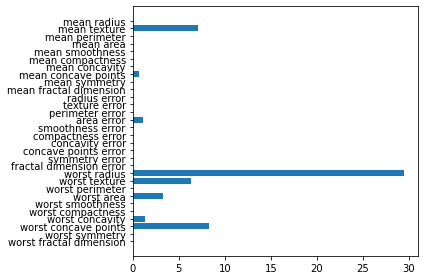

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
y_pos = np.arange(len(feature_importance.keys()))
ax.barh(y_pos, feature_importance.values())
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance.keys())
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [48]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        """Random Forest algorithm.

        Args:
            n_estimators (int): The number of trees in the forest.
            max_features (int): The number of random select features to consider when looking for the best split.
            boostrap (bool): If bootstrap samples are used when building tree.
            criterion (str): The criterion used, should be 'gini' or 'entropy'.
            max_depth (int): The maximum depth of the tree, if is None, then nodes are expanded to the end.
        """
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        if max_depth == None:
            self.max_depth = float('inf')
        else:
            self.max_depth = max_depth
    
    def fit(self, x, y):
        """Fit the model.

        Args:
            x (list): The data.
            y (list): The labels.
        """
        self.trees = list()
        for i in range(self.n_estimators):
            tree = DecisionTree(self.criterion, self.max_depth)
            tree.fit(x, y, self.boostrap, True, self.max_features)
            self.trees.append(tree)

    def apply(self, x, y):
        """Apply the model on given data.

        Args:
            x (list): The data.
            y (list): The labels, only for cheking accuracy.
        Returns:
            accuracy (float): The accuracy of the model.
        """
        x = x.to_numpy()
        y = y.to_numpy()
        labels = np.unique(y)
        correct = 0
        total = len(x)
        for row, features in enumerate(x):
            counts = dict(zip(labels, [0] * len(labels)))
            for tree in self.trees:
                counts[tree.predict(features)] += 1
            label = max(counts, key=counts.get)
            if label == y[row][0]:
                correct += 1

        return correct / total

### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [49]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

In [50]:
clf_10tree.fit(x_train, y_train)

In [51]:
clf_10tree.apply(x_test, y_test)

0.9300699300699301

In [52]:
clf_100tree.fit(x_train, y_train)

In [53]:
clf_100tree.apply(x_test, y_test)

0.9440559440559441

### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [54]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [55]:
clf_random_features.fit(x_train, y_train)

In [56]:
clf_random_features.apply(x_test, y_test)

0.9440559440559441

In [57]:
clf_all_features.fit(x_train, y_train)

In [58]:
clf_all_features.apply(x_test, y_test)

0.9440559440559441

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 